In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset

#### Read dataset

In [3]:
EVdata = pd.read_csv("stationAggDaytoDay2011_2020May12.csv", header = 0, index_col = 0)

In [4]:
EVdata.set_index('StartDate', inplace=True)

In [15]:
EVdata

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942
...,...,...,...,...,...
2020-12-25,WEBSTER 3,1,9.897000,4.157,1.242
2020-12-26,WEBSTER 3,1,10.359000,4.351,1.300
2020-12-29,WEBSTER 3,3,37.291000,15.662,4.680


In [16]:
testData= EVdata.loc[EVdata["Station Name"] == "HAMILTON 1", ["counts", "Energy (kWh)"]]

In [17]:
testData = testData.rename(columns = {"Energy (kWh)": "target"})

In [18]:
testData["item_id"] = "HAMILTON 1"

In [28]:
testData.head()

,counts,target,item_id
StartDate,,,
2011-07-29,1,6.249457,HAMILTON 1
2011-07-30,5,28.978653,HAMILTON 1
2011-07-31,3,37.209163,HAMILTON 1
2011-08-01,1,5.041244,HAMILTON 1
2011-08-02,1,4.197217,HAMILTON 1


In [88]:
from gluonts.dataset.pandas import PandasDataset

#### Handle missing data

In [42]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"): ## gdf is all features for each item_id
    print("item_id: ", item_id, "\n gdf: \n", gdf.shape)
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0

ds = PandasDataset(dfs_dict, target="target")
counts = dfs_dict["HAMILTON 1"].loc[:, "counts"].to_numpy()



item_id:  HAMILTON 1 
 gdf: 
 (3208, 3)


In [43]:
counts

array([1., 5., 3., ..., 2., 0., 1.])

In [23]:
next(iter(ds))

{'start': Period('2011-07-29', 'D'),
 'target': array([ 6.249457, 28.978653, 37.209163, ..., 44.383   ,  0.      ,
         6.545   ]),
 'item_id': 'HAMILTON 1'}

#### Add multiple features

##### Number of counts

In [47]:
prediction_length = 500
freq = "1D"
start = pd.Period('2011-07-29', freq = freq)

In [39]:
from gluonts.dataset.field_names import FieldName

In [59]:
next(iter(ds))["target"].shape

(3386,)

In [58]:
next(iter(ds))["target"][: -prediction_length].shape

(2886,)

##### Temporal variables

In [87]:
from gluonts.time_feature import (
    day_of_week,
    day_of_month,
    day_of_year,
    week_of_year,
    month_of_year,
)

In [111]:
from gluonts.time_feature.holiday import (
   squared_exponential_kernel,
   SpecialDateFeatureSet,
   CHRISTMAS_DAY,
   CHRISTMAS_EVE
)

In [112]:
holidat_set = SpecialDateFeatureSet([CHRISTMAS_EVE, CHRISTMAS_DAY])

In [98]:
start_date = testData.index[0]
end_date = testData.index[-1]
start_date, end_date

(Timestamp('2011-07-29 00:00:00'), Timestamp('2020-11-03 00:00:00'))

In [99]:
date_indices = pd.date_range(
    start = start_date,
    end = end_date,
    freq = 'D'
)

In [102]:
day_of_week_variable = day_of_week(date_indices)
day_of_month_variable = day_of_month(date_indices)
day_year_variable = day_of_year(date_indices)
week_of_year_variable = week_of_year(date_indices)
month_of_year_variable = month_of_year(date_indices)

#### Use train and split

In [105]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            next(iter(ds))["target"][: -prediction_length].reshape(1, next(iter(ds))["target"][: -prediction_length].shape[0]),
            [next(iter(ds))["start"]],
            counts[: -prediction_length].reshape(1, counts[: -prediction_length].shape[0]),
            day_of_week_variable[: -prediction_length].reshape(1, day_of_week_variable[: -prediction_length].shape[0]),
            month_of_year_variable[: -prediction_length].reshape(1, month_of_year_variable[: -prediction_length].shape[0])
        )
    ],
    freq=freq,
)

In [108]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, day_of_week_variable, month_of_year_variable],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            next(iter(ds))["target"].reshape(1, next(iter(ds))["target"].shape[0]),
            [next(iter(ds))["start"]],
            counts.reshape(1, counts.shape[0]),
            day_of_week_variable.reshape(1, day_of_week_variable.shape[0]),
            month_of_year_variable.reshape(1, month_of_year_variable.shape[0])
        )
    ],
    freq=freq,
)

In [109]:
train_ds

[{'target': array([ 6.249457, 28.978653, 37.209164, ..., 24.684   , 19.295   ,
         16.339   ], dtype=float32),
  'start': Period('2011-07-29', 'D'),
  'feat_dynamic_real': array([[ 1.        ,  5.        ,  3.        , ...,  4.        ,
           4.        ,  5.        ],
         [ 0.16666667,  0.33333334,  0.5       , ...,  0.        ,
           0.16666667,  0.33333334],
         [ 0.04545455,  0.04545455,  0.04545455, ..., -0.04545455,
          -0.04545455, -0.04545455]], dtype=float32)}]

In [110]:
test_ds

[{'target': array([ 6.249457, 28.978653, 37.209164, ..., 44.383   ,  0.      ,
          6.545   ], dtype=float32),
  'start': Period('2011-07-29', 'D'),
  'feat_dynamic_real': array([[ 1.        ,  5.        ,  3.        , ...,  2.        ,
           0.        ,  1.        ],
         [ 0.16666667,  0.33333334,  0.5       , ...,  0.5       ,
          -0.5       , -0.33333334],
         [ 0.04545455,  0.04545455,  0.04545455, ...,  0.4090909 ,
           0.4090909 ,  0.4090909 ]], dtype=float32)}]

#### Visualize the dataset

In [113]:
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series

2011-07-29     6.249457
2011-07-30    28.978653
2011-07-31    37.209164
2011-08-01     5.041244
2011-08-02     4.197217
                ...    
2019-06-18    40.965000
2019-06-19    42.328999
2019-06-20    24.684000
2019-06-21    19.295000
2019-06-22    16.339001
Freq: D, Length: 2886, dtype: float32

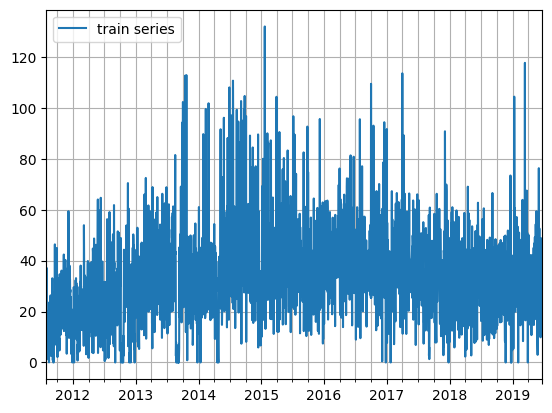

In [114]:
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

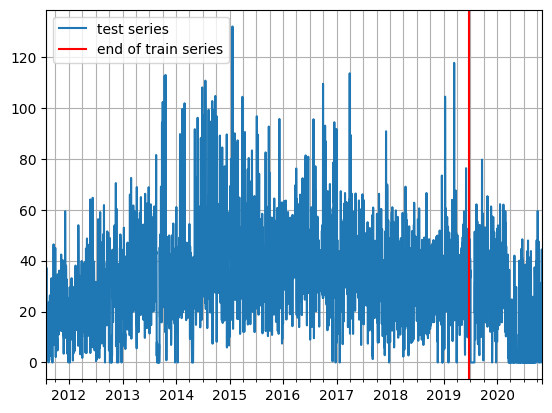

In [115]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [116]:
print(
    f"Length of forecasting window in test dataset: {prediction_length}"
)
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 500
Recommended prediction horizon: 500
Frequency of the time series: 1D


In [117]:
train_entry = next(iter(train_ds))
[k for k in train_entry.keys()]

['target', 'start', 'feat_dynamic_real']

In [118]:
test_entry = next(iter(test_ds))
[k for k in test_entry.keys()]

['target', 'start', 'feat_dynamic_real']

#### Train and prediction

##### Simple feed forward estimator

In [145]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### MQCNN estimator

In [121]:
from gluonts.mx import MQCNNEstimator, Trainer

In [146]:
mqcnn_estimator = MQCNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### MQRNN estimator

In [123]:
from gluonts.mx import MQRNNEstimator, Trainer

In [148]:
mqrnn_estimator = MQRNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### DeepAR estimator

In [125]:
from gluonts.mx import DeepAREstimator, Trainer

In [192]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=False,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [127]:
from gluonts.mx import DeepVAREstimator, Trainer

In [150]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    target_dim= 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### LSTNet

In [129]:
from gluonts.mx import LSTNetEstimator, Trainer

In [191]:
lstnet_estimator = LSTNetEstimator(
    num_series = 1,
    prediction_length = prediction_length,
    ar_window = 10,
    channels = 1,
    context_length = 20,
    skip_size = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [131]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [156]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 10,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [133]:
from gluonts.mx import TransformerEstimator, Trainer

In [157]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    context_length = 100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [135]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [158]:
deepFactor_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [137]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [161]:
gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Naive predictor

In [139]:
from gluonts.ext.naive_2 import Naive2Predictor

In [140]:
naive_predictor = Naive2Predictor(
    prediction_length = prediction_length,
    season_length = 100
)

##### Train and predict

In [141]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

def train_and_predict(train_dataset, test_dataset, estimator):
    predictor = estimator.train(train_dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return forecast_it, ts_it


In [194]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstNetEstimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN
estimator = deepAR_estimator

In [195]:
forecast_it, ts_it = train_and_predict(train_ds, test_ds, estimator)

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:32<01:49,  1.42s/it, epoch=5/10, avg_epoch_loss=3.89]

##### Evaluation

In [181]:
forecast = list(forecast_it)
tss = list(ts_it)

In [182]:
forecast_entry = forecast[0]
ts_entry = tss[0]

In [183]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 500)
Start date of the forecast window: 2019-06-23
Frequency of the time series: <Day>


In [184]:
print(ts_entry)

                    0
2011-07-29   6.249457
2011-07-30  28.978653
2011-07-31  37.209164
2011-08-01   5.041244
2011-08-02   4.197217
...               ...
2020-10-30  25.440001
2020-10-31  15.122000
2020-11-01  44.382999
2020-11-02   0.000000
2020-11-03   6.545000

[3386 rows x 1 columns]


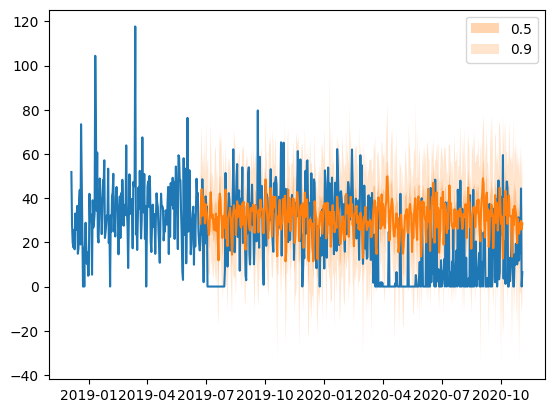

In [185]:
plt.plot(ts_entry[-700:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [186]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecast)

Running evaluation: 1it [00:00,  4.10it/s]


In [187]:
print(estimator, json.dumps(agg_metrics, indent=4))

gluonts.mx.model.simple_feedforward._estimator.SimpleFeedForwardEstimator(batch_normalization=False, batch_size=32, context_length=100, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), imputation_method=None, mean_scaling=True, num_hidden_dimensions=[50], num_parallel_samples=100, prediction_length=500, sampling=True, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, callbacks=None, clip_gradient=10.0, ctx=cpu(0), epochs=10, hybridize=True, init='xavier', learning_rate=0.001, num_batches_per_epoch=10, weight_decay=1e-08), validation_sampler=None) {
    "MSE": 484.82978125,
    "abs_error": 9187.73046875,
    "abs_target_sum": 10153.2109375,
    "abs_target_mean": 20.306421875,
    "seasonal_error": 15.414398288561525,
    "MASE": 1.1920971933841735,
    "MAPE": 1.7779138660963687,
    "sMAPE": 0.9434766235351563,
    "MSIS": 7.833998625143156,
    "QuantileLoss[0.1]": 5859.655629578233,
    "Coverage[0.1]": 0.392,
    "QuantileLoss

In [172]:
agg_metrics["MSE"]

519.316625

In [173]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2019-06-23,519.316625,9576.052734,10153.210938,20.306422,15.414398,1.242482,1.941061,0.942667,0.943155,8.195979,6760.047881,0.468,9576.052039,0.712,3396.227192,0.946


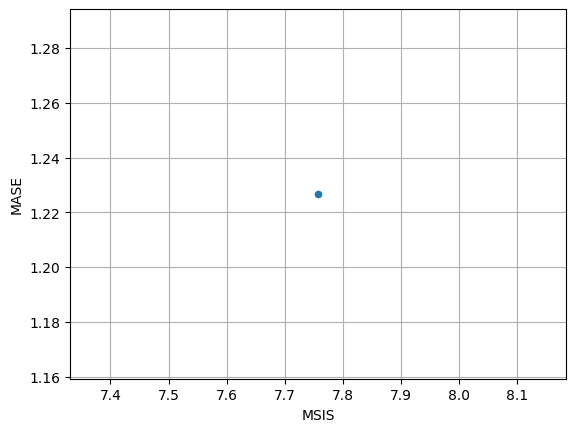

In [55]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()